{% include toc title="In This Lesson" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this tutorial, you will be able to:

* List the MODIS spectral bands and identify which bands should be used to calculate a normalized burn ratio (NBR)
* Import and stack MODIS imagery in `Python`.
* Scale MODIS surface reflectance values to the appropriate range using `Python`. 

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson and the Cold Springs Fire
data.

{% include /data_subsets/course_earth_analytics/_data-cold-springs-fire.md %}

</div>


## Introduction to MODIS Imagery

Moderate Resolution Imaging Spectrometer (MODIS) is a satellite-based instrument that continuously collects
data over the Earth's surface. Currently, MODIS has the finest temporal resolution of the publicly available remote sensing data, spanning the entire globe every 24 hrs. 

MODIS collects data across 36 spectral bands; however, in this class, you will only work with the first 7 bands. 

| Band | Wavelength range (nm) | Spatial Resolution (m) | 
|-------------------------------------|------------------|--------------------|
| Band 1 - red | 620 - 670 | 250 | 
| Band 2 - near infrared | 841 - 876 | 250 | 
| Band 3 -  blue/green | 459 - 479 | 500 |
| Band 4 - green | 545 - 565 | 500 | 
| Band 5 - near infrared  | 1230 – 1250 | 500 | 
| Band 6 - mid-infrared | 1628 – 1652 | 500 | 
| Band 7 - mid-infrared | 2105 - 2155 | 500 | 


### MODIS Surface Reflectance (MOD09GA Product)

There are many different MODIS data products. These are datasets that are processed for use in science. In this class, we are using the MOD09GA product, which is a reflectance product that includes the first 7 bands of MODIS.

The normal range of surface reflectance values is 0 to 1, where 1 is the BRIGHTEST value and 0 is the DARKEST value. Surface reflectance is a measure of the spectral reflectance of the earth's surface, as it would be if measured on the ground. You can think of it as what your eye would see, except of course, your eye can not see light outside of the visible part of the electromagnetic spectrum. 

<a href="https://modis.gsfc.nasa.gov/data/dataprod/mod09.php" target="_blank">MODIS</a> provides many standardized products, including the MOD09GA product of surface reflectance which you will use in this course. The MOD09GA product provides surface reflectance at a spatial resolution of 500m across the 7 spectral bands listed in the table above. 

According to the <a href="http://modis-sr.ltdri.org/" target="_blank">Land Surface Reflectance Science Computing Facility</a>, who creates the MOD09 products, the products are *estimates of the surface spectral reflectance for each band as it would have been measured at ground level as if there were no atmospheric scattering or absorption. It corrects for the effects of atmospheric gases, aerosols, and thin cirrus clouds.*

### Band Metadata for the MOD09GA Product

To better understand the MODIS data, have a look at the <a href="http://modis-sr.ltdri.org/guide/MOD09_UserGuide_v1_3.pdf" target="_blank">detailed table for the MOD09GA product in the MODIS users guide on page 14</a>.

Part of the table is below:

| Science Data Sets (HDF Layers (21)) | Units  | Data Type | Fill Value (no data) | Valid Range | Scale Factor |
|---|---|---|---|---|---|
| surf_Refl_b01: 500m Surface Reflectance Band 1 (620-670 nm) | Reflectance | 16-bit signed integer | -28672 | -100 to 16000 | 0.0001 |
| surf_Refl_b02: 500m Surface Reflectance Band 2 (841-876 nm) | Reflectance | 16-bit signed integer  | -28672 | -100 to 16000 | 0.0001 |
| surf_Refl_b03: 500m Surface Reflectance Band 3 (459-479 nm)| Reflectance | 16-bit signed integer  | -28672 | -100 to 16000 | 0.0001 |
| surf_Refl_b04: 500m Surface Reflectance Band 4 (545-565 nm)| Reflectance | 16-bit signed integer  | -28672 | -100 to 16000 | 0.0001 |
| surf_Refl_b05: 500m Surface Reflectance Band 5 (1230-1250 nm)| Reflectance | 16-bit signed integer  | -28672 | -100 to 16000 | 0.0001 |
| surf_Refl_b06: 500m Surface Reflectance Band 6 (1628-1652 nm) | Reflectance | 16-bit signed integer  | -28672 | -100 to 16000 | 0.0001 |
| surf_Refl_b07: 500m Surface Reflectance Band 7 (2105-2155 nm) | Reflectance | 16-bit signed integer  | -28672 | -100 to 16000 | 0.0001 |

Using this table for the MOD09GA product, answer the following questions:
1. What is valid range of values for our data?
2. What the no data value?
3. What is the scale factor associated with our data?


### Identify MODIS Bands for NBR Calculations

This week in class, you will be calculating NBR using MODIS data. However, even though you can calculate the same vegetaion indices with many different remote sensing produts, remember that the bands for each remote sensing data  are different. 

Review the table above which displays the band ranges for the MODIS sensor. Recall that the NBR index will work with any multispectral sensor with a NIR band between 760 - 900 nm and a SWIR band between 2080 - 2350 nm.

## Open MODIS Imagery

In this lesson, you will learn how to open MODIS data using the pre-fire MODIS imagery for the Cold Springs fire study area in Colorado. 

Before you get started, import the following packages and make sure that your working directory is set.

In [1]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import box

data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In previous lessons, you have used `glob("*keyword*.tif")` to create a list of all files that both:
1. Contain a certain keyword as denoted by the asterisks (e.g. `*band*`) and
2. Contain the extension `.tif`.

Begin by using glob to create a list of MODIS surface reflectance rasters using the keyword and extension `*sur_refl_b*.tif`. 

In [2]:
# Create list of MODIS rasters for surface reflectance
modis_bands_pre_list = glob(os.path.join("cold-springs-fire",
                                         "modis",
                                         "reflectance",
                                         "07_july_2016",
                                         "crop",
                                         "*_sur_refl_b*.tif"))

# Sort the list of bands
modis_bands_pre_list.sort()
modis_bands_pre_list

['cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b01_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b02_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b03_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b04_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b05_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b06_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b07_1.tif']

In [3]:
def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.

    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """

    out_xr = []
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"] = i+1

    return xr.concat(out_xr, dim="band")

Next, use the function `combine_tifs` to create the `rioxarray` object from the list of bands you created using glob. Then, you can import the MODIS bands and create a RGB plot. 

In [4]:
# Open file list with function

modis_bands_pre = combine_tifs(modis_bands_pre_list)

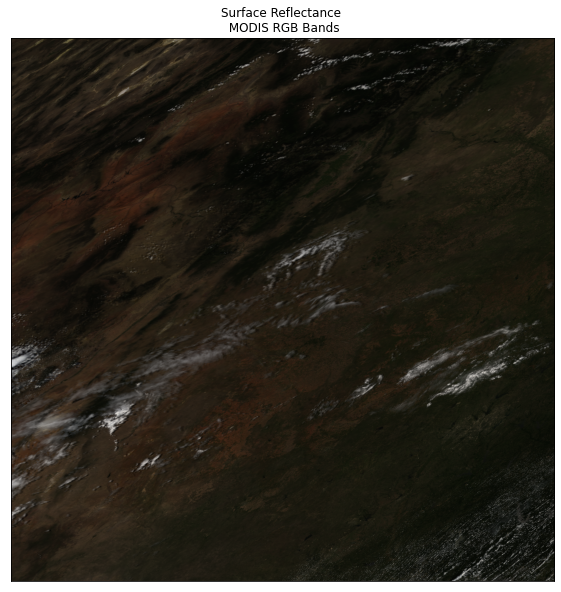

In [5]:
# Plot MODIS RGB
# Take out the masked values to plot with ep.plot_rgb
modis_bands_pre_plot = ma.masked_array(
    modis_bands_pre.values, modis_bands_pre.isnull())

ep.plot_rgb(modis_bands_pre_plot,
            rgb=[0, 3, 2],
            title="Surface Reflectance \n MODIS RGB Bands")
plt.show()

## Explore Data Values

To start exploring the data, you can calculate the minimum and maximum values of select bands to see the range of values. For example, you can calculate these values for the first band (red) of the MODIS stack. 

In [6]:
# Identify minimum and maximum values of band 1 (red)
print(modis_bands_pre[1].min(), modis_bands_pre[1].max())

<xarray.DataArray ()>
array(-100.)
Coordinates:
    band         int64 2
    spatial_ref  int64 0 <xarray.DataArray ()>
array(10039.)
Coordinates:
    band         int64 2
    spatial_ref  int64 0


The data being opened is great! However, you also need to crop the data for your homework. You can do this in two easy steps. 

1. Reproject the fire boundary, so that it is in the same CRS as your MODIS data
2. Crop the MODIS data using the fire boundary and the `xarray_name.rio.clip()` function. To use this function with a GeoPandas object, you have to call the geometry column of the geopandas object. To clarify
```
xarray_name.rio.clip(crop_bound)
```
will not work, but 
```
xarray_name.rio.clip(crop_bound.geometry)
```
will work! 

However, this method will clip the scene too the exact outline of a vector shape. This can be useful, but often you will want to clip a rectangle that covers the boundaries of the vector shape, instead of the exact shape. To do this, you can use the `box` function, imported from `shapely.geometry`, to create a box around the geometry you want to clip.

`xarray_name.rio.clip([box(*crop_bound.total_bounds)])`

Below you can see the difference in how the two methods clip a scene!

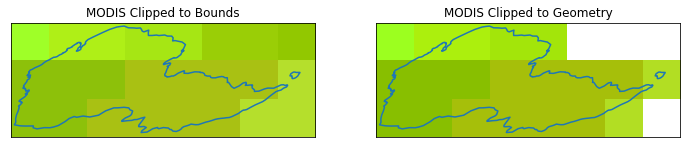

In [16]:
# Open fire boundary
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")
fire_boundary = gpd.read_file(fire_boundary_path)
fire_bound_sin = fire_boundary.to_crs(modis_bands_pre.rio.crs)

fire_bound_box = [box(*fire_bound_sin.total_bounds)]


# MODIS Clipped to Geometry
modis_clip_geometry = modis_bands_pre.rio.clip(fire_bound_sin.geometry,
                                               all_touched=True,
                                               from_disk=True)

# MODIS Clipped to Bounds
modis_clip = modis_bands_pre.rio.clip(fire_bound_box,
                                      all_touched=True,
                                      from_disk=True)

extent = plotting_extent(modis_clip[0].values, modis_clip.rio.transform())

modis_clip_plot = ma.masked_array(modis_clip.values, modis_clip.isnull())
modis_clip_geometry_plot = ma.masked_array(modis_clip_geometry.values, modis_clip_geometry.isnull())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 15))

# Plotting Geometry Clip
ep.plot_rgb(modis_clip_plot,
            rgb=[0, 3, 2],
            ax=ax1,
            extent=extent,
            title='MODIS Clipped to Bounds')

fire_bound_sin.boundary.plot(ax=ax1)

# Plotting Bounds Clip
ep.plot_rgb(modis_clip_geometry_plot,
            rgb=[0, 3, 2],
            ax=ax2,
            extent=extent,
            title='MODIS Clipped to Geometry')

fire_bound_sin.boundary.plot(ax=ax2)

plt.show()

For the purposes of NDVI and NBR analysis, we are interested in surrounding areas, as well as the pixels directly inside the geometry, so for this analysis we will be using the `bounds` method. 

To explore the cropped data, recall that you can also use the `plot_bands` function in `earthpy` to create plots of each band.

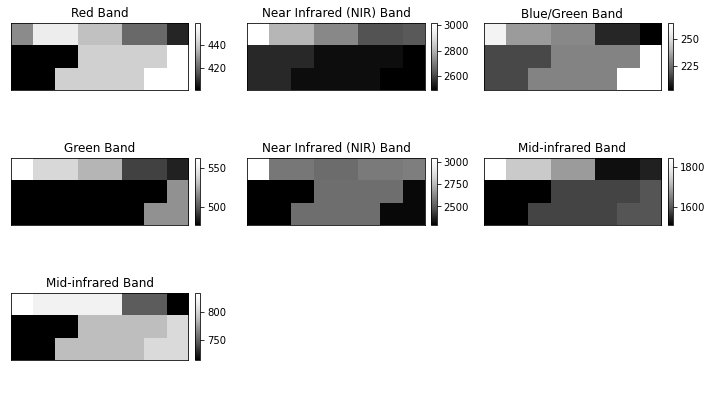

In [8]:
# Create a list of titles
titles = ["Red Band", "Near Infrared (NIR) Band", "Blue/Green Band", "Green Band",
          "Near Infrared (NIR) Band", "Mid-infrared Band", "Mid-infrared Band"]

# Plot all bands individually
ep.plot_bands(modis_clip,
              cols=3,
              title=titles,
              figsize=(10, 6))
plt.show()

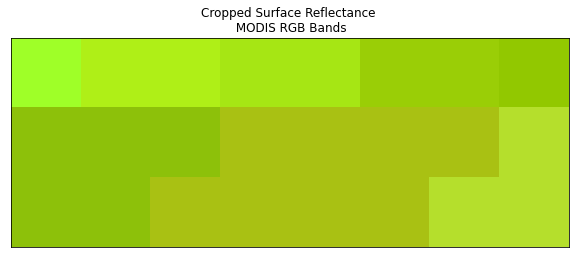

In [9]:
# Plot MODIS RGB
modis_clip_plot = ma.masked_array(modis_clip.values, modis_clip.isnull())


ep.plot_rgb(modis_clip_plot,
            rgb=[0, 3, 2],
            title='Cropped Surface Reflectance \n MODIS RGB Bands')

plt.show()

This looks better. Now the nodata values are masked from the data. 

Next, create histograms to look at the distribution of pixel values. Does the range of values look reasonable?

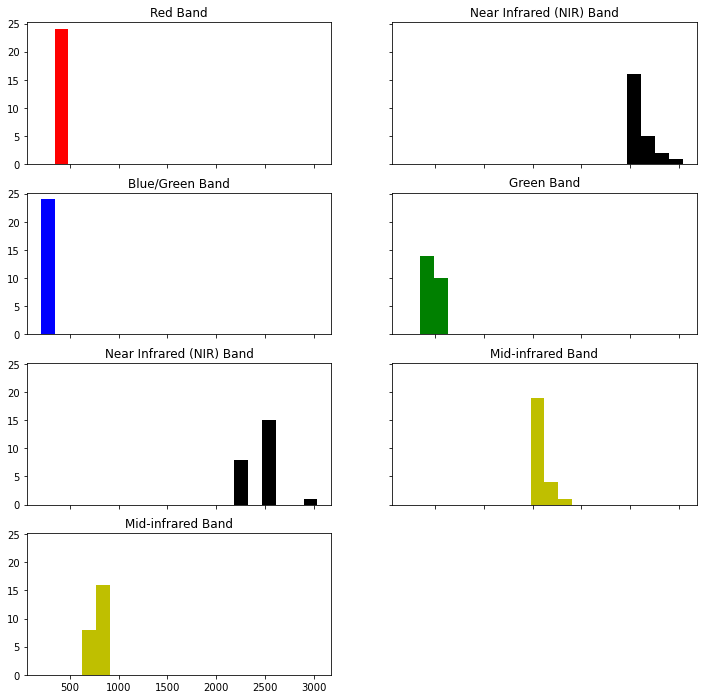

In [10]:
# Create a colors and titles list to use in the histogram
colors = ['r', 'k', 'b', 'g', 'k', 'y', 'y']
titles = ["Red Band", "Near Infrared (NIR) Band", "Blue/Green Band",
          "Green Band", "Near Infrared (NIR) Band",
          "Mid-infrared Band", "Mid-infrared Band"]

# Plot histogram
ep.hist(modis_clip.values,
        colors=colors,
        title=titles,
        cols=2)
plt.show()

From the histograms, you can see that the range of values for surface reflectance appear more appropriate, but are still not between 0 and 1. 

## Reflectance Values in MODIS Imagery

As noted previously in the lesson, the normal range of reflectance values is 0 to 1, where 1 is the BRIGHTEST values and 0 is the DARKEST value. 

Look again at the minimum and maximum values that you calculated above for band 1. What do you notice?

As you can see, the minimum and maximum values are widely outside of the expected range of 0 to 1. Looking at histogram of band 1, you can also see that the range of values is not what you would expect. 

What could be causing this? To answer this question, you need to better understand the data before you can work with it more. 

## Scale Factor

Scale factors are common when using remote sensing data. The data are large and scale factors are used to keep the data smaller in size. For example, it takes much more space to store numbers with decimals (known as floating points) than it does to store an integer. Thus often remove sensing data have a scale factor applied that can be used to 

Looking at the table for the MOD09GA product, you can see that the MODIS data have a scale factor of 0.0001. This means you should multiply each layer by that value to get the actual reflectance values of the data.

You can apply this scale factor value to all of the layers in your stack using numpy array math sometimes referred to as raster math in GIS tools. Here you multiply the entire array by .0001 to scale each layer or band.

In [11]:
# Scale values of MODIS imagery stack
modis_bands_pre_scaled = modis_clip * 0.0001

Now the range of values for surface reflectance are within the appropriate range (0 and 1). 

In [12]:
# Identify minimum and maximum values of scaled band 1 (red)
print(modis_bands_pre_scaled[1].min(), modis_bands_pre_scaled[1].max())

<xarray.DataArray ()>
array(0.2496)
Coordinates:
    band         int64 2
    spatial_ref  int64 0 <xarray.DataArray ()>
array(0.3013)
Coordinates:
    band         int64 2
    spatial_ref  int64 0


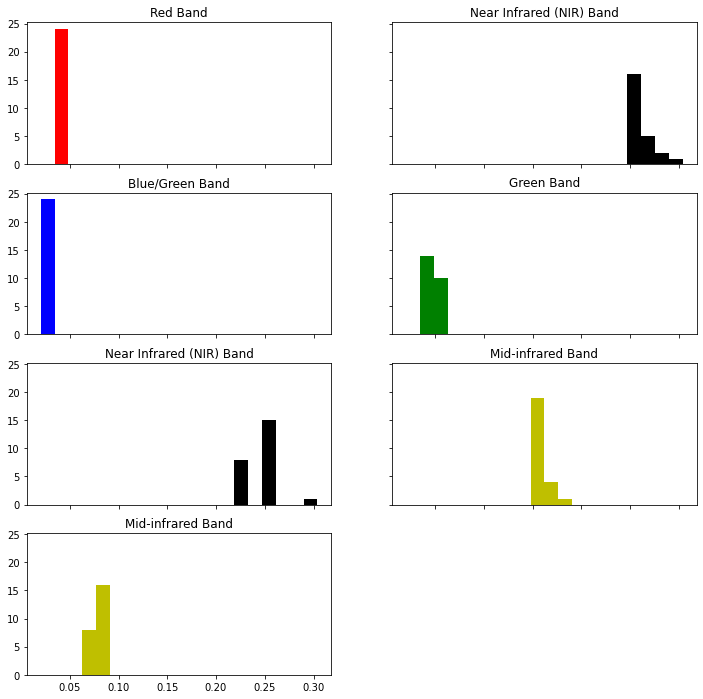

In [13]:
# Create a colors and titles list to use in the histogram
colors = ['r', 'k', 'b', 'g', 'k', 'y', 'y']
titles = ["Red Band", "Near Infrared (NIR) Band", "Blue/Green Band", "Green Band",
          "Near Infrared (NIR) Band", "Mid-infrared Band", "Mid-infrared Band"]

# Plot histogram
ep.hist(modis_bands_pre_scaled.values,
        colors=colors,
        title=titles,
        cols=2)
plt.show()

Now, you have a MODIS surface reflectance stack that you can use in further analysis. You are ready to calculate dNBR for your homework! 